Graph convolutional network for fMRI analysis based on connectivity neighborhood:
The paper outlines a methodology for converting functional connectivity (FC) matrices from fMRI data into graph structures using a k-nearest neighbors (k-NN) approach. The k-NN graph is built by connecting each node (ROI) to its k nearest neighbors based on the strength of connectivity, which is represented by the FC matrix values.

In [15]:
import nibabel as nib
import numpy as np
import networkx as nx
import os
import math
import pandas as pd
from tqdm.notebook import tqdm  # Import tqdm for notebooks
import matplotlib.pyplot as plt
import subprocess
import pickle
#import utils
from itertools import combinations_with_replacement
from tqdm import tqdm
import seaborn as sns


In [2]:
def load_fc_matrix(file_path):
    """ Load functional connectivity matrix from a .pconn.nii file. """
    img = nib.load(file_path)
    fc_matrix = img.get_fdata()
    return fc_matrix

def create_knn_graph(fc_matrix, k=5):
    """ Create a graph from a functional connectivity matrix using k-nearest neighbors based on absolute values. """
    n = fc_matrix.shape[0]  # Number of nodes
    G = nx.Graph()
    for i in range(n):
        G.add_node(i)
    
    # For each node, add edges to the k-nearest neighbors based on absolute values of connectivity strengths
    for i in range(n):
        # Sort indices based on the absolute values, get the k highest values indices for each row
        indices = np.argsort(np.abs(fc_matrix[i]))[-k:]
        for j in indices:
            if i != j:  # Ensure no self-loops
                G.add_edge(i, j, weight=fc_matrix[i][j])
    
    return G
def create_threshold_graph(fc_matrix, std_multiplier=2):
    """
    Create a graph from a functional connectivity matrix by adding edges where the 
    absolute connection strength is above a threshold defined as a multiple of the
    standard deviation of the absolute values in the connectivity matrix.
    """
    n = fc_matrix.shape[0]  # Number of nodes
    G = nx.Graph()
    
    # Calculate the threshold as std_multiplier times the standard deviation of the absolute values
    threshold = std_multiplier * np.std(np.abs(fc_matrix))
    
    # Add nodes
    for i in range(n):
        G.add_node(i)
    
    # Add edges based on the threshold
    for i in range(n):
        for j in range(n):
            if i != j and np.abs(fc_matrix[i, j]) > threshold:  # Avoid self-loops and check threshold
                G.add_edge(i, j, weight=fc_matrix[i, j])
    
    return G

In [3]:
import os
import matplotlib.pyplot as plt


def plot(G, orbits):
    fig, axes = plt.subplots(3, 5)
    fig.suptitle(G.name)

    for o in range(15):
        nk = {}
        for i in range(len(G)):
            k = orbits[i][o]
            if k not in nk:
                nk[k] = 0
            nk[k] += 1
        ks = sorted(nk.keys())

        axes[o // 5, o % 5].loglog(ks, [nk[k] / len(G)
                                   for k in ks], 'ok', markersize=1)
        axes[o // 5, o % 5].set_xticks([])
        axes[o // 5, o % 5].set_yticks([])

    plt.savefig(G.name + ".png", bbox_inches='tight')
    plt.close()


def orca(G, exe_folder=".", output_folder=".", num_orbits=5):
    orca_executable = os.path.join(exe_folder, 'orca')
    if not os.path.isfile(orca_executable):
        raise Exception(f"{orca_executable} does not exist or is not a file")
    
    input_file = os.path.join(output_folder, f"{G.name}.in")
    output_file = os.path.join(output_folder, f"{G.name}.orca")
    
    # Write the graph to the input file
    with open(input_file, 'w') as file:
        file.write(f"{G.number_of_nodes()} {G.number_of_edges()}\n")
        for i, j in G.edges():
            file.write(f"{i} {j}\n")

    # Building the command
    command = [orca_executable, "node", str(num_orbits), input_file, output_file]

    # Running the command
    try:
        result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, check=True)
        #print("ORCA ran successfully:", result.stdout)
        print("ORCA ran successfully")
    except subprocess.CalledProcessError as e:
        print(f"Error running ORCA: {e.stderr}")
        return []

    # Read the output file and parse orbits
    orbits = []
    with open(output_file, 'r') as file:
        for line in file:
            orbits.append([int(k) for k in line.split()])

    return orbits

def calculate_agreement(orbits1, orbits2):
    # Ensure the orbit counts are in numpy arrays for easier manipulation
    orbits1 = np.array(orbits1, dtype=float)
    orbits2 = np.array(orbits2, dtype=float)

    # Avoid log of zero by replacing zero values with a small number
    orbits1[orbits1 == 0] = 1e-10
    orbits2[orbits2 == 0] = 1e-10

    # Calculate the logarithm of orbit frequencies
    log_orbits1 = np.log(orbits1)
    log_orbits2 = np.log(orbits2)

    # Calculate orbit agreement Ai for each orbit type
    Ai = 1 - np.sqrt(0.5 * np.sum((log_orbits1 - log_orbits2)**2, axis=1))
    # Make sure Ai does not contain invalid values for the geometric mean
    Ai[Ai <= 0] = 1e-10  # Replace non-positive values with a small positive number
    # Arithmetic and geometric means of Ai
    A_arithmetic = np.mean(Ai)
    A_geometric = np.prod(np.power(Ai, 1/len(Ai)))

    return A_arithmetic, A_geometric
def get_orbits(file_name,std_multiplier=4.5,num_orbits=5):
    file_extension = '.pconn.nii'
    fc_file_path = os.path.join(directory, file_name+file_extension)
    fc_matrix = load_fc_matrix(fc_file_path)
    #graph = create_knn_graph(fc_matrix, k=5)
    graph = create_threshold_graph(fc_matrix,std_multiplier=std_multiplier)
    graph.name = file_name  # Ensure the graph has a name attribute
    # Usage example
    exe_folder = '/home/tico/Desktop/master_classes/project/orca'
    output_folder = '/home/tico/Desktop/master_classes/project/output'
    orbits = orca(graph, exe_folder, output_folder,num_orbits)
    return orbits
def compute_and_save_orbits(file_name, output_dir,std_multiplier=4.5,num_orbits=5):
    orbit_file = os.path.join(output_dir, file_name + '.pkl')
    
    # Check if orbits already computed and saved
    if os.path.exists(orbit_file):
        with open(orbit_file, 'rb') as f:
            orbits = pickle.load(f)
    else:
        orbits = get_orbits(file_name,std_multiplier,num_orbits)  # Ensure this function is defined to compute orbits
        
        # Save the computed orbits to a file for future use
        with open(orbit_file, 'wb') as f:
            pickle.dump(orbits, f)
    
    return orbits

In [4]:
std_multipliers = [4.5,4.2,4.8]
num_orbitss = [5,4]
# Ensure output directory exists
for std_multiplier in std_multipliers:
    for num_orbits in num_orbitss:
        str_std_multiplier = str(std_multiplier).replace('.','-')
        orbits_dir = f'/home/tico/Desktop/master_classes/project/orbits_{str_std_multiplier}_{num_orbits}'
        print(orbits_dir)
        print(len(os.listdir(orbits_dir)))

/home/tico/Desktop/master_classes/project/orbits_4-5_5
638
/home/tico/Desktop/master_classes/project/orbits_4-5_4
638
/home/tico/Desktop/master_classes/project/orbits_4-2_5
638
/home/tico/Desktop/master_classes/project/orbits_4-2_4
638
/home/tico/Desktop/master_classes/project/orbits_4-8_5
203
/home/tico/Desktop/master_classes/project/orbits_4-8_4
1


In [17]:
behavior_path = '/home/tico/Desktop/master_classes/project/behavior/'
behavior_files = os.listdir(behavior_path)

behavior_source = pd.read_csv(behavior_path+behavior_files[0], sep='\t')
for behavior_file in behavior_files[1:]:
    curr_behavior_source = pd.read_csv(behavior_path+behavior_file, sep='\t')
    behavior_source = pd.concat([behavior_source, curr_behavior_source], axis=0)
behavior_source = behavior_source[["session_id","Group"]]
behavior_source



directory = "/home/tico/Desktop/master_classes/project/BSNIP/pconn"
pconn_files = [f for f in os.listdir(directory) if f.endswith('.pconn.nii')]

#std_multipliers = [4.5,4.2,4.8]
num_orbitss = [5,4]
std_multipliers = [4.8]
# Ensure output directory exists
for std_multiplier in std_multipliers:
    for num_orbits in num_orbitss:
        str_std_multiplier = str(std_multiplier).replace('.','-')
        orbits_dir = f'/home/tico/Desktop/master_classes/project/orbits_{str_std_multiplier}_{num_orbits}'
        os.makedirs(orbits_dir, exist_ok=True)
        #orbits = get_orbits(pconn_files[0][:-len('.pconn.nii')])
        for file_path in pconn_files:
            orbits = compute_and_save_orbits(file_path[:-len('.pconn.nii')], orbits_dir,std_multiplier,num_orbits)          

ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran successfully
ORCA ran s

KeyboardInterrupt: 

In [8]:
# Assuming the data loading and initial preparation steps have been done as before
behavior_files = os.listdir('/home/tico/Desktop/master_classes/project/behavior/')
behavior_data = [pd.read_csv(f'/home/tico/Desktop/master_classes/project/behavior/{f}', sep='\t') for f in behavior_files]
behavior_source = pd.concat(behavior_data)
behavior_source = behavior_source[['session_id', 'Group']]
# Set up the DataFrame for storing agreements
unique_groups = behavior_source['Group'].unique()
agreements_arithmetic = pd.DataFrame(0.0, index=unique_groups, columns=unique_groups)
agreements_geometric = pd.DataFrame(0.0, index=unique_groups, columns=unique_groups)

In [26]:
# Assuming compute_and_save_orbits and calculate_agreement functions are defined
# Also assuming behavior_source DataFrame is already defined

std_multiplier = 4.2
str_std_multiplier = str(std_multiplier).replace('.', '-')
num_orbits = 4
orbits_dir = f'/home/tico/Desktop/master_classes/project/orbits_{str_std_multiplier}_{num_orbits}'

# Create a list of unique session IDs and groups
sessions = behavior_source['session_id'].unique()
groups = behavior_source.set_index('session_id')['Group'].to_dict()

# Initialize matrices for arithmetic and geometric agreements
agreements_arithmetic = pd.DataFrame(np.zeros((len(sessions), len(sessions))), index=sessions, columns=sessions)
agreements_geometric = pd.DataFrame(np.zeros((len(sessions), len(sessions))), index=sessions, columns=sessions)

# Calculate the total number of iterations for the progress bar
total_iterations = sum(len(data1['session_id']) * len(data2['session_id']) for _, data1 in behavior_source.groupby('Group') for _, data2 in behavior_source.groupby('Group'))
progress_bar = tqdm(total=total_iterations, desc="Computing agreements")

# Compute agreements across all combinations of sessions
for (group1, data1), (group2, data2) in combinations_with_replacement(behavior_source.groupby('Group'), 2):
    for session1 in data1['session_id']:
        orb1 = compute_and_save_orbits(session1, orbits_dir, std_multiplier, num_orbits)
        for session2 in data2['session_id']:
            if session1 == session2:
                progress_bar.update(1)
                continue
            if agreements_arithmetic.at[session1, session2] == 0:  # Check if not already computed
                orb2 = compute_and_save_orbits(session2, orbits_dir, std_multiplier, num_orbits)
                A_arithmetic, A_geometric = calculate_agreement(orb1, orb2)
                agreements_arithmetic.at[session1, session2] = A_arithmetic
                agreements_geometric.at[session1, session2] = A_geometric
                agreements_arithmetic.at[session2, session1] = A_arithmetic  # Symmetric assignment
                agreements_geometric.at[session2, session1] = A_geometric  # Symmetric assignment
            progress_bar.update(1)

progress_bar.close()

# After filling the upper triangle, copy the diagonal elements
np.fill_diagonal(agreements_arithmetic.values, 0)
np.fill_diagonal(agreements_geometric.values, 0)

# Sort sessions based on groups
sorted_sessions = sorted(sessions, key=lambda x: groups[x])

# Sort the matrices
agreements_arithmetic_sorted = agreements_arithmetic.loc[sorted_sessions, sorted_sessions]
agreements_geometric_sorted = agreements_geometric.loc[sorted_sessions, sorted_sessions]

# Create a mapping from session ID to group for sorted sessions
sorted_groups = [groups[session] for session in sorted_sessions]

Computing agreements:  63%|██████▎   | 256199/407044 [03:04<01:48, 1387.10it/s] 


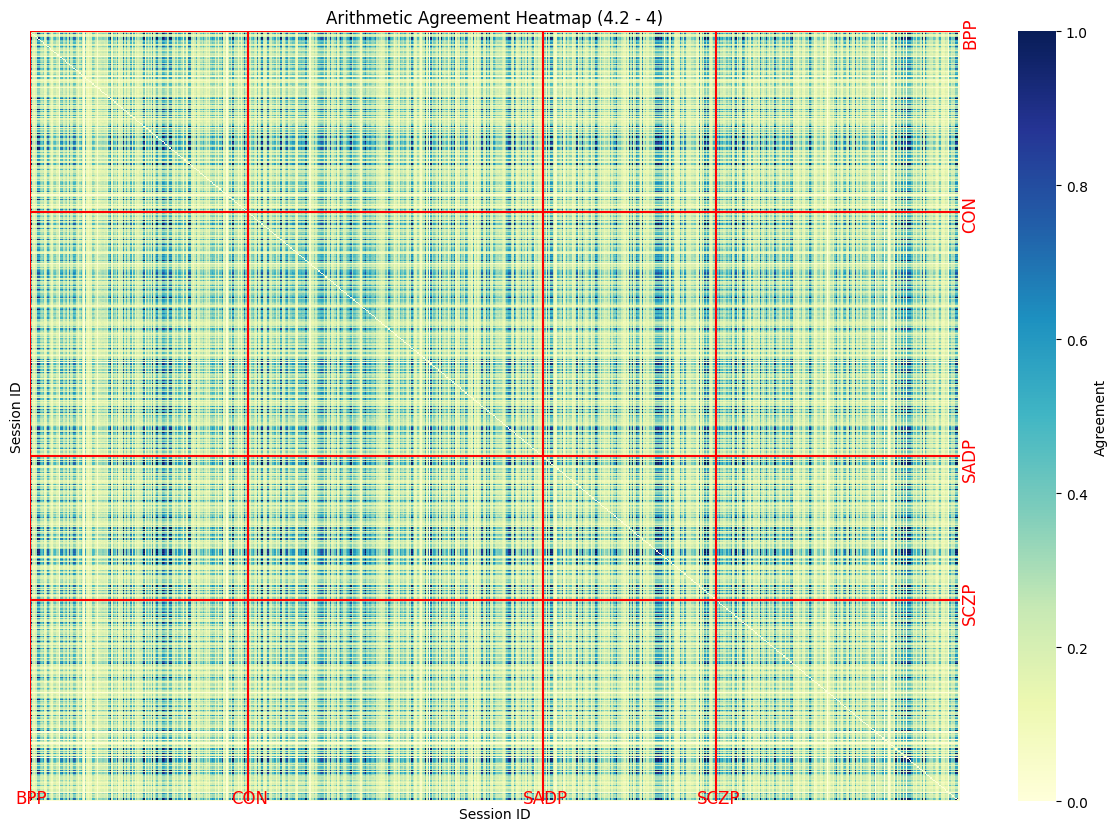

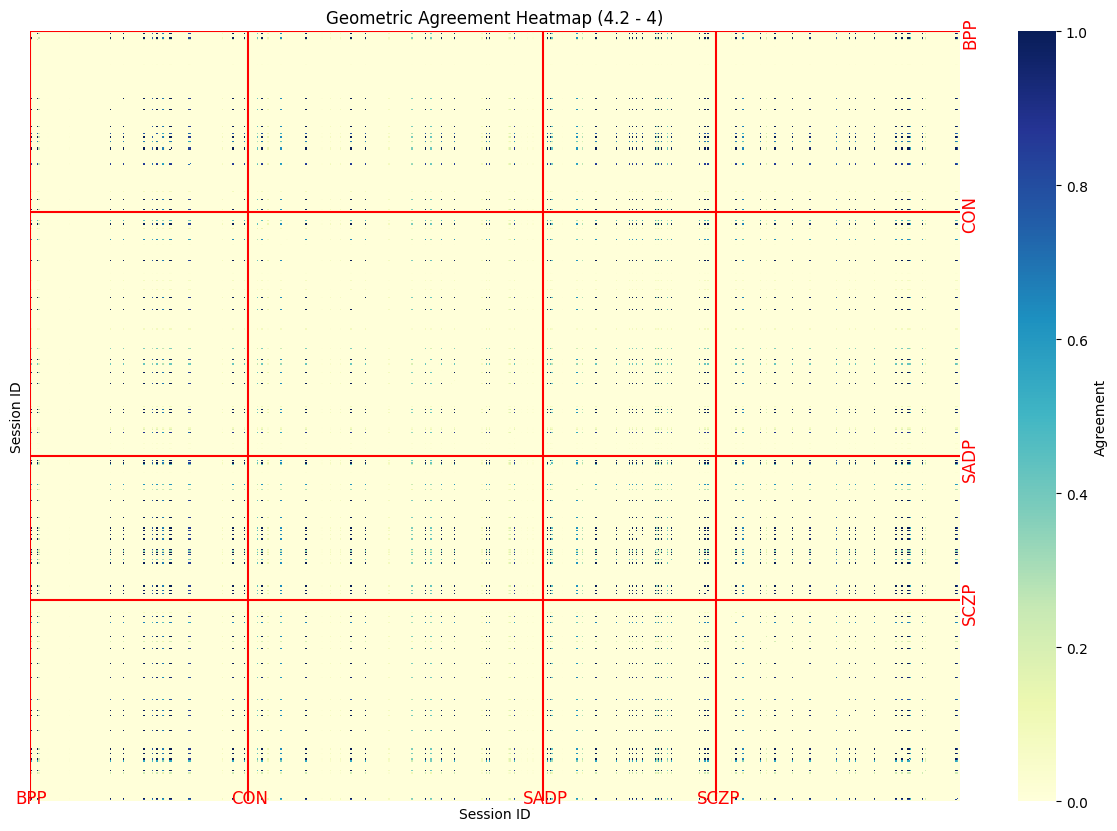

In [27]:
# Sort sessions based on groups
sorted_sessions = sorted(sessions, key=lambda x: groups[x])

# Sort the matrices
agreements_arithmetic_sorted = agreements_arithmetic.loc[sorted_sessions, sorted_sessions]
agreements_geometric_sorted = agreements_geometric.loc[sorted_sessions, sorted_sessions]

# Create a mapping from session ID to group for sorted sessions
sorted_groups = [groups[session] for session in sorted_sessions]

# Plot the heatmap with group boundaries
def plot_heatmap_with_groups(matrix, title):
    plt.figure(figsize=(15, 10))
    ax = sns.heatmap(matrix, cmap="YlGnBu", cbar_kws={'label': 'Agreement'}, xticklabels=False, yticklabels=False)

    # Add group boundaries
    boundary_indices = []
    current_group = sorted_groups[0]
    boundary_indices.append(0)  # Add the first boundary for the first group
    
    for idx, group in enumerate(sorted_groups):
        if group != current_group:
            boundary_indices.append(idx)
            current_group = group

    for boundary in boundary_indices:
        ax.axhline(boundary, color='red', linewidth=1.5)
        ax.axvline(boundary, color='red', linewidth=1.5)
    
    # Adding labels for group sections
    unique_groups = sorted(set(sorted_groups), key=sorted_groups.index)
    for boundary, group in zip(boundary_indices, unique_groups):
        ax.text(boundary + len(group)//2, len(matrix) + 1, group, horizontalalignment='center', fontsize=12, color='red')
        ax.text(len(matrix) + 1, boundary + len(group)//2, group, verticalalignment='center', fontsize=12, color='red', rotation=90)
    
    plt.title(title)
    plt.xlabel("Session ID")
    plt.ylabel("Session ID")
    plt.savefig(title.replace(" ", "_")+'.pdf', format='pdf')
    plt.show()

# Plot arithmetic agreement heatmap
plot_heatmap_with_groups(agreements_arithmetic_sorted, "Arithmetic Agreement Heatmap (4.2 - 4)")

# Plot geometric agreement heatmap
plot_heatmap_with_groups(agreements_geometric_sorted, "Geometric Agreement Heatmap (4.2 - 4)")

In [8]:
# Normalize the results by the number of comparisons
for group1 in unique_groups:
    for group2 in unique_groups:
        total_pairs = len(behavior_source[behavior_source['Group'] == group1]) * len(behavior_source[behavior_source['Group'] == group2])
        agreements_arithmetic.at[group1, group2] /= total_pairs
        agreements_geometric.at[group1, group2] /= total_pairs

# Output the results
print("Arithmetic Agreements:")
print(agreements_arithmetic)
print("\nGeometric Agreements:")
print(agreements_geometric)

Arithmetic Agreements:
          SCZP       CON       BPP      SADP
SCZP  0.459528  0.485333  0.461829  0.467920
CON   0.485333  0.519123  0.491318  0.498038
BPP   0.461829  0.491318  0.470697  0.473543
SADP  0.467920  0.498038  0.473543  0.484014

Geometric Agreements:
          SCZP       CON       BPP      SADP
SCZP  0.032661  0.033799  0.032131  0.037147
CON   0.033799  0.045638  0.039376  0.045502
BPP   0.032131  0.039376  0.042962  0.043270
SADP  0.037147  0.045502  0.043270  0.056700
